In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import nivapy3 as nivapy
import rpy2.rinterface

%load_ext rpy2.ipython

# Generalised Additive Models (GAMs) for the 1000 Lakes dataset

A quick attempt at using a GAM to explore variations in Ca concentration.

## 1. Prepare data using Python

In [2]:
# Read data
df = pd.read_csv('1000_lakes_lw_am.csv')
df = df.query('(value_am >= 0) and (status == "Authorised")')
df.head()

,sample_id,station_id,station_name,station_type,sample_date,parameter,status,loq,value_lw,units,value_am
308,104436,26199.0,Storbørja,Innsjø,2019-10-25,Total organisk karbon (TOC),Authorised,"<0,10",15.200,MG_C_L,9.800
309,104436,26199.0,Storbørja,Innsjø,2019-10-25,Alkalitet,Authorised,"<0,030",0.049,MMOLE_P_L,0.042
310,104436,26199.0,Storbørja,Innsjø,2019-10-25,Konduktivitet,Authorised,"<0,1",1.950,MS_P_M,1.850
311,104436,26199.0,Storbørja,Innsjø,2019-10-25,Fluorid,Authorised,<2,43.000,UG_P_L,40.000
312,104436,26199.0,Storbørja,Innsjø,2019-10-25,Klorid,Authorised,"<0,005",1.260,MG_P_L,1.200


In [3]:
# Read station co-ords
stn_df = pd.read_excel('am1000sjoer.xlsx', sheet_name='StationPoint')
stn_df = stn_df[['StationId', 'Latitude', 'Longitude']]
stn_df.columns = ['station_id', 'lat', 'lon']

# Join
df = pd.merge(df, stn_df, how='left', on='station_id')
df.rename({'value_lw':2019,
           'value_am':1995},
          axis=1,
          inplace=True)

df = df[['station_id', 'station_name', 'lat', 'lon', 'parameter', 1995, 2019]]

# Some samples seem to have been analysed and approved more than once?
df = df.groupby(by=['station_id', 'station_name', 'lat', 'lon', 'parameter']).mean()
df.reset_index(inplace=True)

In [4]:
# Restructure
df = pd.melt(df, 
             id_vars=['station_id', 'station_name', 'lat', 'lon', 'parameter'],
             var_name='year')

df.set_index(['station_id', 'station_name', 'lat', 'lon', 'parameter', 'year'],
             inplace=True)

df = df.unstack('parameter')
df.reset_index(inplace=True)
df.columns = list(df.columns.get_level_values(0)[:5]) + list(df.columns.get_level_values(1)[5:])
df.columns = [i.replace(" ", "") for i in df.columns]

# WGS to UTM
df = nivapy.spatial.wgs84_dd_to_utm(df, lat='lat', lon='lon', utm_zone=33)

# Save
df.to_csv('gam_data.csv', index=False)

df

,station_id,station_name,lat,lon,year,Alkalitet,Aluminium,"Aluminium,ikkelabil","Aluminium,reaktivt",Ammonium,...,Nitritt+nitrat,Sink,Sulfat,Totalfosfor,Totalnitrogen,Totalorganiskkarbon(TOC),pH,utm_north,utm_east,utm_zone
0,26070.0,Langtjern,59.808643,11.850274,1995,0.042,NaN,111.0,131.0,NaN,...,46.0,NaN,3.00,10.0,385.0,11.70,5.39,6.634299e+06,323345.999797,33
1,26070.0,Langtjern,59.808643,11.850274,2019,0.054,NaN,130.0,150.0,NaN,...,16.0,NaN,0.61,11.0,250.0,20.00,5.09,6.634299e+06,323345.999797,33
2,26071.0,Hokksjøen,59.004423,11.563586,1995,0.032,NaN,141.0,202.0,NaN,...,90.0,NaN,4.80,10.0,485.0,10.00,5.03,6.545620e+06,302651.000302,33
3,26071.0,Hokksjøen,59.004423,11.563586,2019,0.030,NaN,220.0,280.0,NaN,...,48.0,NaN,1.89,10.0,370.0,24.20,4.67,6.545620e+06,302651.000302,33
4,26072.0,Sætertjern,60.060222,12.446711,1995,0.049,NaN,130.0,182.0,NaN,...,38.0,NaN,3.00,8.0,385.0,12.10,5.49,6.660863e+06,357866.000000,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,46323.0,Skjelbreida,60.629145,10.566392,2019,0.138,NaN,24.0,26.0,NaN,...,195.0,NaN,1.54,NaN,360.0,7.80,6.67,6.729662e+06,257539.751506,33
1934,46550.0,Vråsjåen,60.035994,8.055995,1995,0.052,NaN,10.0,12.0,NaN,...,19.0,NaN,0.70,NaN,89.0,0.98,6.15,6.675744e+06,113576.280104,33
1935,46550.0,Vråsjåen,60.035994,8.055995,2019,0.068,NaN,6.0,9.0,NaN,...,4.0,NaN,0.43,NaN,65.0,1.30,6.42,6.675744e+06,113576.280104,33
1936,46620.0,Nøklevatn,60.483064,11.795074,1995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,6.709499e+06,323896.430509,33


In [5]:
# Summary for Ca in each time period
df.groupby(by='year').describe().T.loc['Kalsium']

year,1995,2019
count,862.000000,862.000000
mean,2.035093,2.339698
std,3.264762,3.397086
min,0.040000,0.110000
25%,0.390000,0.550000
50%,0.945000,1.185000
75%,2.320000,2.590000
max,36.100000,35.400000


## 2. Build GAM using R

In [6]:
%%R

# Load packages
library(mgcv)
library(ggplot2)
library(dplyr)
library(viridis)

# Read dataset
df = read.csv('gam_data.csv')
head(df)

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:nlme’:

    collapse


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: viridisLite



  station_id station_name      lat      lon year Alkalitet Aluminium
1      26070    Langtjern 59.80864 11.85027 1995     0.042        NA
2      26070    Langtjern 59.80864 11.85027 2019     0.054        NA
3      26071    Hokksjøen 59.00442 11.56359 1995     0.032        NA
4      26071    Hokksjøen 59.00442 11.56359 2019     0.030        NA
5      26072   Sætertjern 60.06022 12.44671 1995     0.049        NA
6      26072   Sætertjern 60.06022 12.44671 2019     0.057        NA
  Aluminium.ikkelabil Aluminium.reaktivt Ammonium Arsen Bly    Ca.Mg Fluorid
1                 111                131       NA    NA  NA 3.459459      40
2                 130                150       NA    NA  NA 3.314286      21
3                 141                202       NA    NA  NA 1.567164      40
4                 220                280       NA    NA  NA 1.448276      31
5                 130                182       NA    NA  NA 2.648148     180
6                 130                200       NA    NA


Family: gaussian 
Link function: identity 

Formula:
Kalsium ~ te(utm_east, utm_north) + s(pH) + year

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -13.315770   4.896504  -2.719  0.00661 **
year          0.007732   0.002440   3.169  0.00156 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df       F p-value    
te(utm_east,utm_north) 16.239 17.657   31.25  <2e-16 ***
s(pH)                   8.798  8.988 1077.96  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.879   Deviance explained = 88.1%
GCV = 1.3998  Scale est. = 1.3773    n = 1676


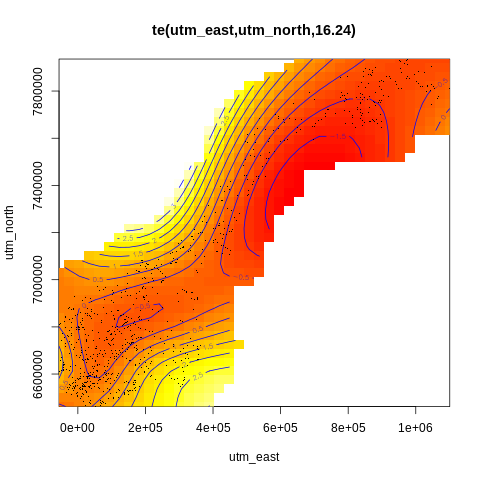

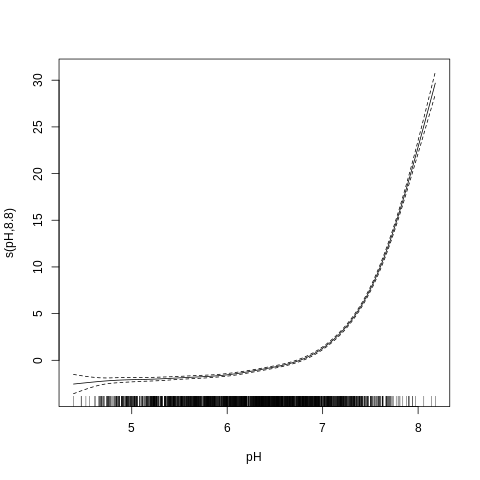

In [7]:
%%R

# Explore models
model = gam(Kalsium ~ te(utm_east, utm_north) + s(pH) + year,
            data=df)

plot(model, scheme = 2)
summary(model)